# Lista de Exercícios 10

**Aluno**: Vítor Gabriel Reis Caitité

**Enunciado:**

A base de dados “wine.xlsx” contém informações associadas às características visuais e degustativas de uma amostra de vinhos. As seguintes informações estão disponíveis:

    a) Claridade (Clarity)
    b) Aroma
    c) Corpo (Body)
    d) Sabor (Flavor)
    e) Característica de carvalho (Oakiness)
    f) Qualidade (Quality)

Além das informações listadas acima, também está disponível a informação da região de origem do vinho (Region). O objetivo deste desafio é estimar modelos que sejam capazes de predizer a região de origem do vinho a partir das informações de características (claridade, aroma, corpo, sabor, oakiness e qualidade). Por se
tratar de um problema de classificação multi-classes, devem ser avaliados múltiplos modelos logísticos e o modelo multinomial. A análise final deve incluir
a matriz de confusão avaliadas em um processo de validação cruzada do tipo leave-one-out.

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_curve, precision_recall_curve
import seaborn as sns


## Leitura do Dataset



In [79]:
dataset = pd.read_excel('~/Documents/UFMG/Doutorado/materias/parametric-and-nonparametric-regression-models/exercise_10/wine.xlsx', header=0)
dataset.head(5)
dataset

,Clarity,Aroma,Body,Flavor,Oakiness,Quality,Region_y
0,1.0,3.3,2.8,3.1,4.1,9.8,1
1,1.0,4.4,4.9,3.5,3.9,12.6,1
2,1.0,3.9,5.3,4.8,4.7,11.9,1
3,1.0,3.9,2.6,3.1,3.6,11.1,1
4,1.0,5.6,5.1,5.5,5.1,13.3,1
5,1.0,4.6,4.7,5.0,4.1,12.8,1
6,1.0,4.8,4.8,4.8,3.3,12.8,1
7,1.0,5.3,4.5,4.3,5.2,12.0,1
8,1.0,4.3,4.3,3.9,2.9,13.6,3
9,1.0,4.3,3.9,4.7,3.9,13.9,1


## Análise Exploratória

### Matriz de Correlação




A matriz abaixo exibe a correlação entre as variáveis do conjunto de dados.

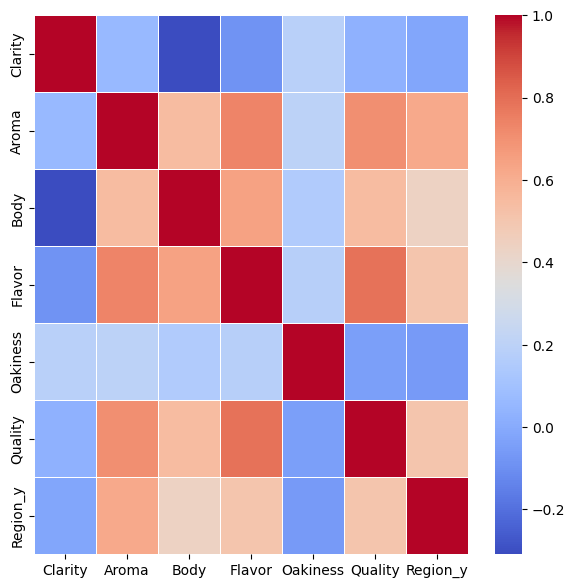

In [80]:
correlation_matrix = dataset.corr()

# Mapa de calor da correlação
plt.figure(figsize=(7, 7))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [81]:
# Listando as maiores correlações em ordem crescente:
correlation_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
filtered_pairs = correlation_pairs[correlation_pairs < 1].drop_duplicates()
print("Maiores correlações:")
print(filtered_pairs.head(10))

Maiores correlações:
Flavor    Quality     0.790047
          Aroma       0.736561
Quality   Aroma       0.707324
Body      Flavor      0.646659
Region_y  Aroma       0.620101
Aroma     Body        0.548910
Body      Quality     0.548702
Quality   Region_y    0.507049
Region_y  Flavor      0.505918
Body      Region_y    0.435440
dtype: float64


### Distribuição de Regiões

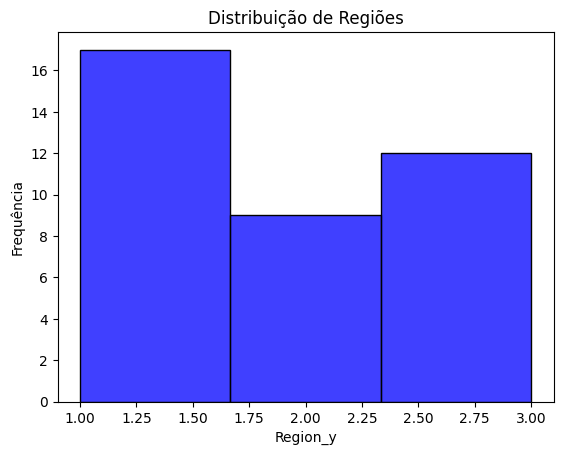

In [82]:
sns.histplot(dataset['Region_y'], bins=3, color='blue')
plt.title("Distribuição de Regiões")
plt.xlabel("Region_y")
plt.ylabel("Frequência")
plt.show()

## Relação entre cada variável e a variável y

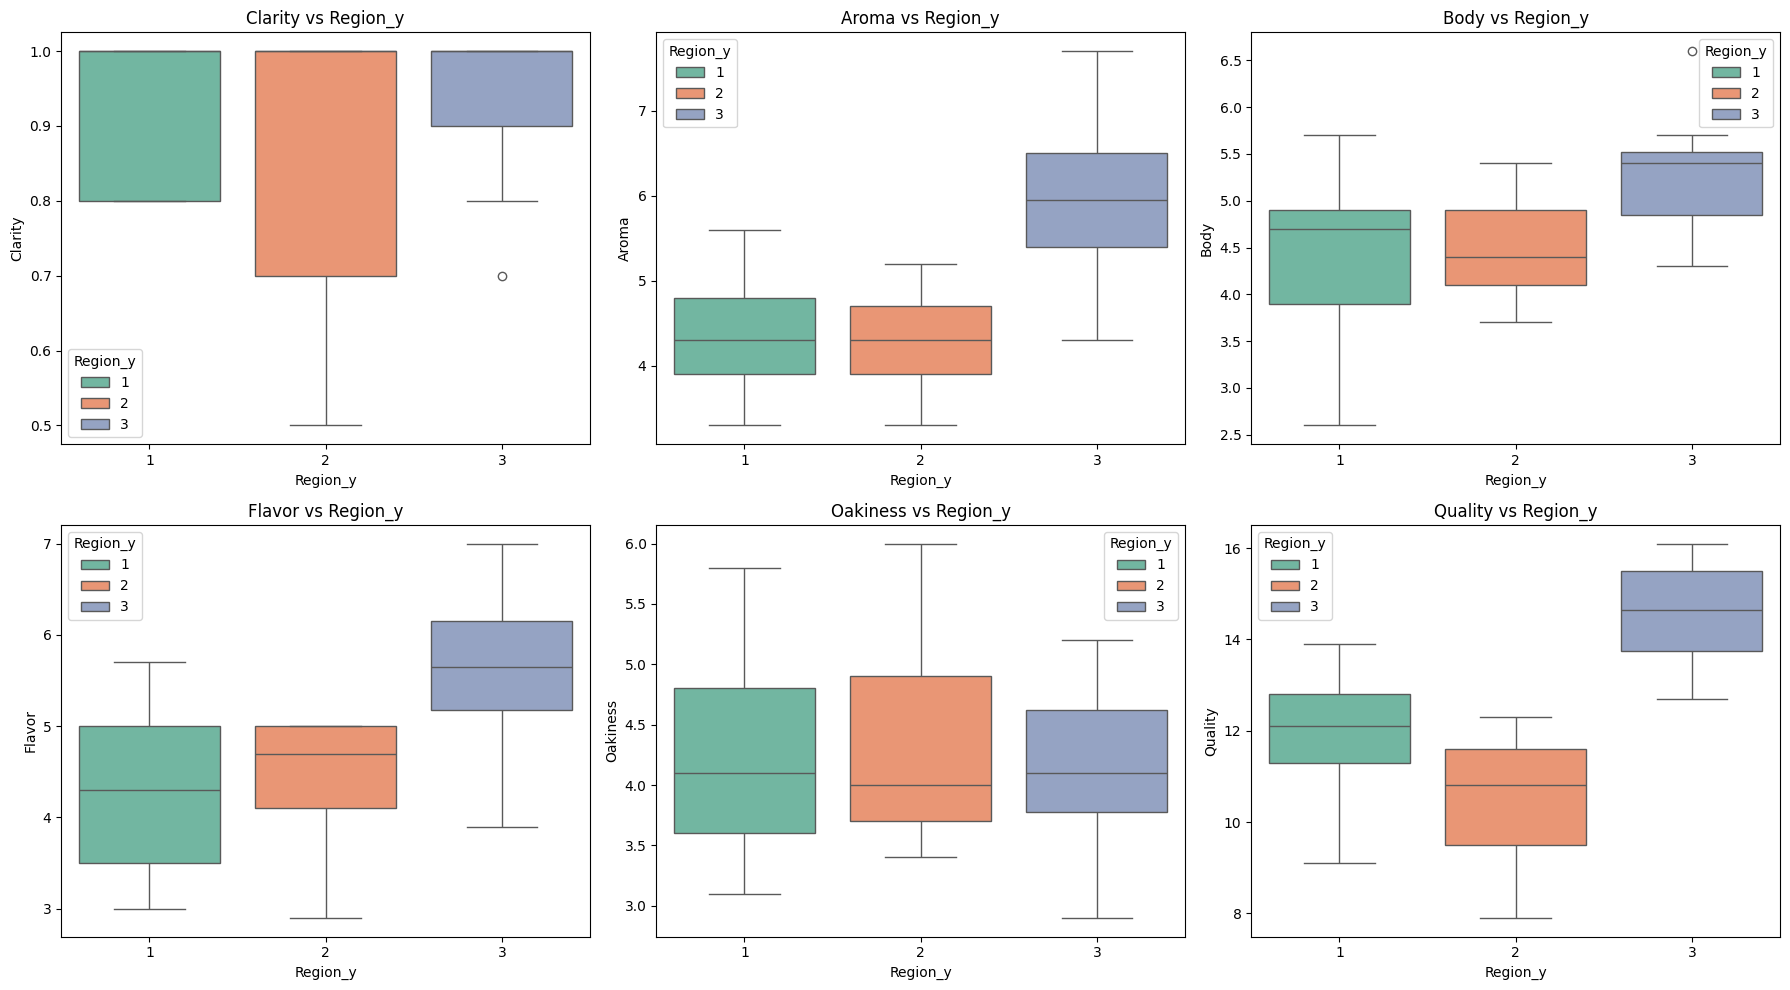

In [83]:
vars = ['Clarity', 'Aroma', 'Body', 'Flavor', 'Oakiness', 'Quality']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  
axes = axes.flatten()  

for i, var in enumerate(vars):
    sns.boxplot(ax=axes[i], x='Region_y', y=var, hue='Region_y', data=dataset, dodge=False, palette='Set2')
    axes[i].set_title(f"{var} vs Region_y")
    axes[i].set_xlabel("Region_y")
    axes[i].set_ylabel(var)
    axes[i].tick_params(axis='x') 
plt.tight_layout()
plt.show()

Pelos gráficos acima pode-se notar que utilizando as **features** "Aroma", "Flavor" e "Quality" pode-se facilmente distinguir a Região 3 das outras.

## Codificação One-Hot para a variável Y.

In [84]:
# Transformando a variável 'Region_y' em variáveis one-hot:
make_mapping = {
    1: 'Region_1',
    2: 'Region_2',
    3: 'Region_3'
}

dataset['Region_y'] = dataset['Region_y'].map(make_mapping)
dataset_regionY_encoded = pd.get_dummies(dataset['Region_y']).astype(int)
dataset_encoded = pd.concat([dataset, dataset_regionY_encoded], axis=1)
dataset = dataset_encoded.drop(['Region_y'], axis=1)
dataset.head(5)

,Clarity,Aroma,Body,Flavor,Oakiness,Quality,Region_1,Region_2,Region_3
0,1.0,3.3,2.8,3.1,4.1,9.8,1,0,0
1,1.0,4.4,4.9,3.5,3.9,12.6,1,0,0
2,1.0,3.9,5.3,4.8,4.7,11.9,1,0,0
3,1.0,3.9,2.6,3.1,3.6,11.1,1,0,0
4,1.0,5.6,5.1,5.5,5.1,13.3,1,0,0


## Múltiplos Modelos Logísticos

### Desenvolvimento do algoritmo de um modelo logístico

In [85]:
class myLogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=10000, tolerance=1e-5):
        self.learning_rate = learning_rate  
        self.epochs = epochs  
        self.weights = None  
        self.bias = 0  
        self.tolerance = tolerance 

    # Função Sigmoid
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    # Função de Custo Log-Loss
    def compute_cost(self, y, y_pred):
        m = len(y)
        cost = -(1/m) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        return cost

    # Função de Treinamento utilizando Gradiente Descendente
    def fit(self, X, y):
        m, n = X.shape  
        self.weights = np.zeros(n)  # Pesos inicializados com zero
        prev_cost = float('inf')
        for epoch in range(self.epochs):
            # 1. Predição do modelo com os pesos atuais:
            y_pred = self.sigmoid(np.dot(X, self.weights) + self.bias)

            # 2. Calcular o custo (log-loss)
            cost = self.compute_cost(y, y_pred)

            # 3. Verificar a convergência
            if abs(prev_cost - cost) < self.tolerance:
                print(f"Critério de parada atingido na iteração {epoch}. Custo: {cost:.4f}")
                break

            # 4. Gradiente descendente: calcular os gradientes
            dw = (1/m) * np.dot(X.T, (y_pred - y))  # Gradiente dos pesos
            db = (1/m) * np.sum(y_pred - y)  # Gradiente do viés

            # 5. Atualizar os parâmetros (pesos e viés)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Atualização do custo anterior
            prev_cost = cost  

    # Função de Previsão
    def predict(self, X):
        y_pred = self.sigmoid(np.dot(X, self.weights) + self.bias)
        return y_pred >= 0.5  

    # Função de Previsão que retorna probabilidades
    def predict_proba(self, X):
        y_prob = self.sigmoid(np.dot(X, self.weights) + self.bias)
        return np.vstack([1 - y_prob, y_prob]).T 

### Funções auxiliares para avaliar o modelo.

In [86]:
# Função para plotar Matriz de Confusão
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):
    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    plt.figure(figsize=(7,4))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="BuPu", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
    plt.show()

In [87]:
# Função para plotar a curva ROC
def plot_roc_curve(y_true, y_pred_prob, auc):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance (AUC = 0.50)')
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


In [88]:
# Validação cruzada Leave-One-Out
def apply_cross_validation(X, y, model, params={}, scale=False): 
    loo = LeaveOneOut()
    y_true = []
    y_pred = []
    y_pred_prob = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if scale:
            normalizer = MinMaxScaler()
            X_train = normalizer.fit_transform(X[train_index])
            X_test = normalizer.transform(X[test_index])
        clf = model(**params)
        clf.fit(X_train, y_train)
        y_pred.append(clf.predict(X_test)[0])
        y_true.append(y_test[0])
        prob = clf.predict_proba(X_test)[0][1] # probabilidade da classe 1
        y_pred_prob.append(prob)

    # plot da matriz de confusão:
    plot_confusion_matrix(y_true, y_pred, [0, 1])

    # Calculos de acurácia e AUC:
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_prob)
    print(f"Acurácia: {accuracy:.2f}")
    print(f"AUC: {auc:.2f}")

    # plot da curva ROC:
    plot_roc_curve(y_true, y_pred_prob, auc)

### Aplicando o modelo logístico considerando cada região separadamente:

************************** Modelo considerando y=Region_1**********************************
Critério de parada atingido na iteração 1906. Custo: 0.5491
Critério de parada atingido na iteração 1906. Custo: 0.5406
Critério de parada atingido na iteração 1876. Custo: 0.5388
Critério de parada atingido na iteração 1881. Custo: 0.5479
Critério de parada atingido na iteração 2006. Custo: 0.5189
Critério de parada atingido na iteração 1905. Custo: 0.5308
Critério de parada atingido na iteração 2086. Custo: 0.5135
Critério de parada atingido na iteração 1903. Custo: 0.5330
Critério de parada atingido na iteração 2151. Custo: 0.5130
Critério de parada atingido na iteração 1865. Custo: 0.5457
Critério de parada atingido na iteração 2065. Custo: 0.5223
Critério de parada atingido na iteração 2147. Custo: 0.5104
Critério de parada atingido na iteração 1888. Custo: 0.5471
Critério de parada atingido na iteração 1990. Custo: 0.5514
Critério de parada atingido na iteração 1897. Custo: 0.5479
Critério

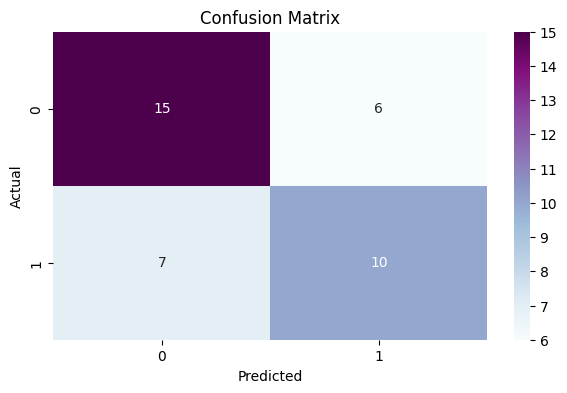

Acurácia: 0.66
AUC: 0.68


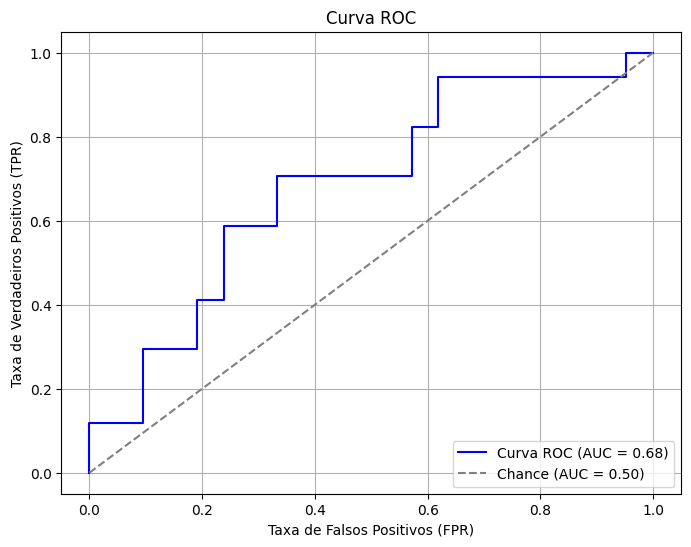

************************** Modelo considerando y=Region_2**********************************
Critério de parada atingido na iteração 6786. Custo: 0.1741
Critério de parada atingido na iteração 6791. Custo: 0.1745
Critério de parada atingido na iteração 6384. Custo: 0.1755
Critério de parada atingido na iteração 6790. Custo: 0.1742
Critério de parada atingido na iteração 6745. Custo: 0.1759
Critério de parada atingido na iteração 6764. Custo: 0.1750
Critério de parada atingido na iteração 6793. Custo: 0.1747
Critério de parada atingido na iteração 6803. Custo: 0.1751
Critério de parada atingido na iteração 6751. Custo: 0.1741
Critério de parada atingido na iteração 6775. Custo: 0.1744
Critério de parada atingido na iteração 6753. Custo: 0.1741
Critério de parada atingido na iteração 5878. Custo: 0.1495
Critério de parada atingido na iteração 6636. Custo: 0.1737
Critério de parada atingido na iteração 6715. Custo: 0.1757
Critério de parada atingido na iteração 6773. Custo: 0.1744
Critério

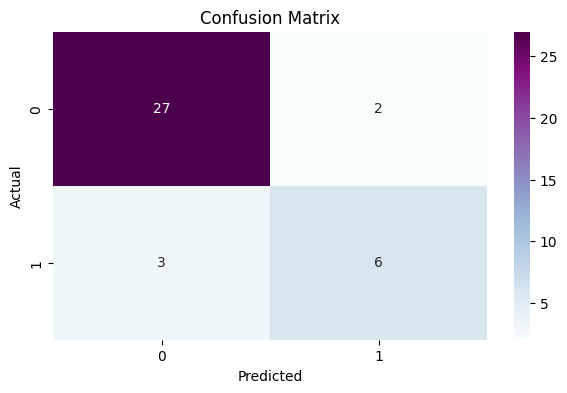

Acurácia: 0.87
AUC: 0.91


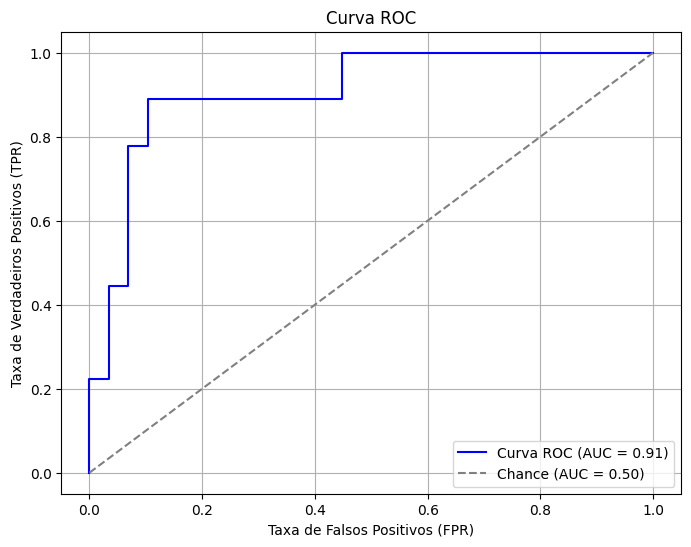

************************** Modelo considerando y=Region_3**********************************
Critério de parada atingido na iteração 6636. Custo: 0.0831
Critério de parada atingido na iteração 6593. Custo: 0.0830
Critério de parada atingido na iteração 6628. Custo: 0.0830
Critério de parada atingido na iteração 6600. Custo: 0.0838
Critério de parada atingido na iteração 6612. Custo: 0.0832
Critério de parada atingido na iteração 6619. Custo: 0.0834
Critério de parada atingido na iteração 6401. Custo: 0.0828
Critério de parada atingido na iteração 6616. Custo: 0.0831
Critério de parada atingido na iteração 6576. Custo: 0.0834
Critério de parada atingido na iteração 6577. Custo: 0.0837
Critério de parada atingido na iteração 6607. Custo: 0.0834
Critério de parada atingido na iteração 6554. Custo: 0.0827
Critério de parada atingido na iteração 6604. Custo: 0.0832
Critério de parada atingido na iteração 6642. Custo: 0.0830
Critério de parada atingido na iteração 6649. Custo: 0.0829
Critério

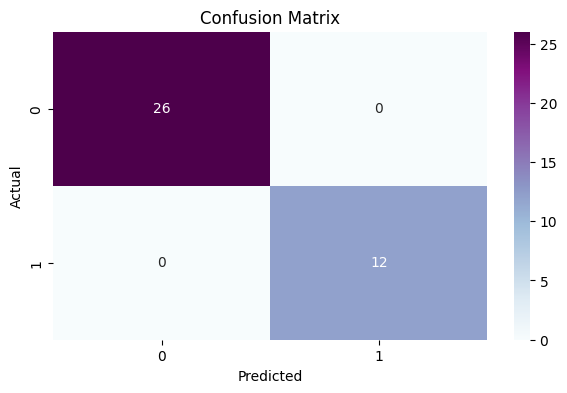

Acurácia: 1.00
AUC: 1.00


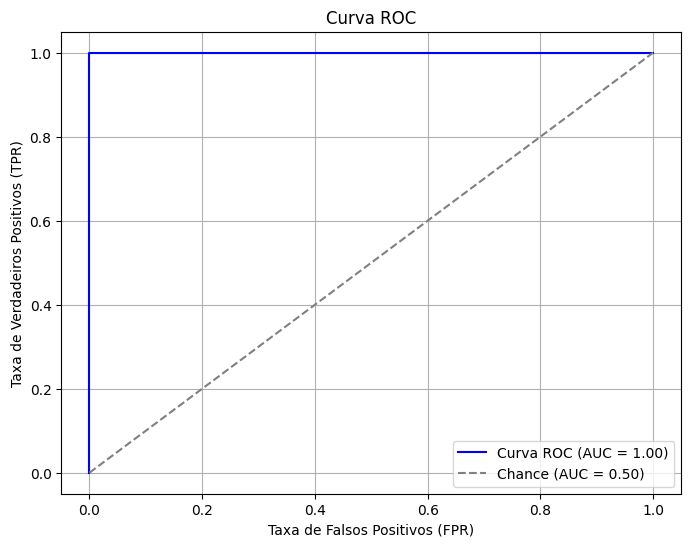

In [89]:
mapping = ['Region_1','Region_2','Region_3']
clf = myLogisticRegression
for i in [-3, -2, -1]:
    # Validação cruzada
    print(f"************************** Modelo considerando y={mapping[i]}**********************************")
    X = dataset.iloc[:,:i].astype(float).to_numpy()
    y = dataset.iloc[:,i].astype(float).to_numpy()
    apply_cross_validation(X, y, clf)

## Modelo Multinomial

Como visto no livro texto, para um problema de 3 classes o modelo multinomial resolve o seguinte sistema de equações:

$P_A + P_B + P_C$

$\frac{P_B}{P_A} = \exp(\eta_b)$

$\frac{P_C}{P_A} = \exp(\eta_c)$

onde:
  - $\eta_b = \beta_0^B + \beta_1^B x_1 + \beta_2^B x_2$, 
  - $\eta_c = \beta_0^C + \beta_1^C x_1 + \beta_2^C x_2$, 
  - $P_A = P(Y^A = 1)$, 
  - $P_B = P(Y^B = 1)$,
  - $P_C = P(Y^C = 1)$.

A solução para esse sistema é:

$P_A = \frac{1}{1 + \exp(\eta_b) + \exp(\eta_c)}$

$P_B = \frac{\exp(\eta_b)}{1 + \exp(\eta_b) + \exp(\eta_c)}$

$P_C = \frac{\exp(\eta_c)}{1 + \exp(\eta_b) + \exp(\eta_c)}$

Nota-se que essas equações correspondem à forma da função softmax quando os logits para as classes são $\eta_A=0$, $\eta_B$ e $\eta_C$ ​. A função softmax, nesse caso, é usada para transformar os logits $\eta_B$ e $\eta_C$​ em probabilidades, com a probabilidade da classe A sendo implicitamente associada à constante 1 (quando $\eta_A=0$).

A forma geral da função softmax para 3 classes seria:

$P_A = \frac{\exp(\eta_A)}{\exp(\eta_A) + \exp(\eta_B) + \exp(\eta_C)}$

$P_B = \frac{\exp(\eta_B)}{\exp(\eta_A) + \exp(\eta_B) + \exp(\eta_C)}$

$P_C = \frac{\exp(\eta_C)}{\exp(\eta_A) + \exp(\eta_B) + \exp(\eta_C)}$


### Desenvolvimento do algoritmo de um modelo multinomial

In [94]:
# Code to train and apply Multinomial Regression Models
class MyMultinomialRegression:
    def __init__(self, learning_rate=0.01, epochs=10000, tolerance=1e-5):
        self.learning_rate = learning_rate 
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.tolerance = tolerance

    def softmax(self, z):
        exp_z = np.exp(z)
        return exp_z/np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        log_likelihood = -np.log(np.sum(y_true * y_pred, axis=1))  # Negative log of true class probability
        loss = np.sum(log_likelihood)/y_true.shape[0]
        return loss

    # Fit the model using gradient descent
    def fit(self, X, y):
        
        m, n = X.shape
        num_classes = y.shape[1]

        # Initialize weights and bias
        self.weights = np.zeros((X.shape[1], num_classes))
        self.bias = np.zeros((1, num_classes))
        prev_loss = float('inf')

        # Gradient descent loop
        for epoch in range(self.epochs):
            # Compute the linear combination (logits)
            logits = np.dot(X, self.weights) + self.bias

            # Apply softmax to get class probabilities
            y_pred = self.softmax(logits)

            # Compute the loss
            loss = self.cross_entropy_loss(y, y_pred)

            # 3. Verificar a convergência
            if abs(prev_loss - loss) < self.tolerance:
                print(f"Critério de parada atingido na iteração {epoch}. Custo: {loss:.4f}")
                break

            # Compute gradients
            errors = y_pred - y 
            dW = np.dot(X.T, errors)/X.shape[0]  
            db = np.sum(errors, axis=0, keepdims=True)/X.shape[0]

            # Update weights and bias using gradient descent
            self.weights -= self.learning_rate * dW
            self.bias -= self.learning_rate * db
            prev_loss = loss

    # Using the learned weights returns class with highest probability
    def predict(self, X):
        logits = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(logits)
        return np.argmax(y_pred, axis=1) 

    # Using the learned weights returns probability for each class
    def predict_proba(self, X):
        logits = np.dot(X, self.weights) + self.bias
        return self.softmax(logits)  


Critério de parada atingido na iteração 4667. Custo: 0.5882
Critério de parada atingido na iteração 4743. Custo: 0.5814
Critério de parada atingido na iteração 4892. Custo: 0.5665
Critério de parada atingido na iteração 4532. Custo: 0.5871
Critério de parada atingido na iteração 4387. Custo: 0.5727
Critério de parada atingido na iteração 4323. Custo: 0.5820
Critério de parada atingido na iteração 4549. Custo: 0.5469
Critério de parada atingido na iteração 4488. Custo: 0.5837
Critério de parada atingido na iteração 4559. Custo: 0.5726
Critério de parada atingido na iteração 4463. Custo: 0.5864
Critério de parada atingido na iteração 4440. Custo: 0.5798
Critério de parada atingido na iteração 5793. Custo: 0.4847
Critério de parada atingido na iteração 4577. Custo: 0.5853
Critério de parada atingido na iteração 4690. Custo: 0.5889
Critério de parada atingido na iteração 4704. Custo: 0.5886
Critério de parada atingido na iteração 4331. Custo: 0.5745
Critério de parada atingido na iteração 

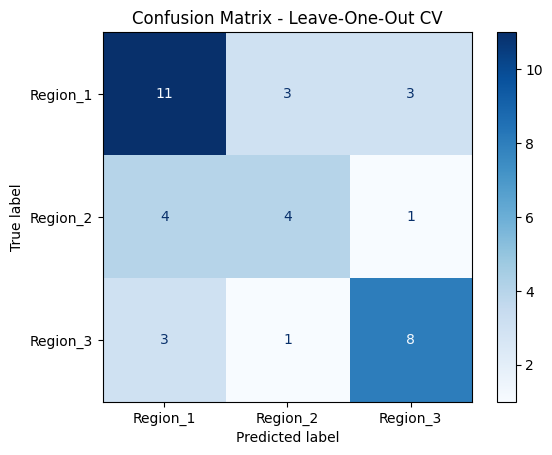

In [95]:
from sklearn.metrics import ConfusionMatrixDisplay

# Função para treinar e avaliar o modelo com LOO
def loo_confusion_matrix_multinomial(X, y, class_names, model_class, **model_kwargs):
    loo = LeaveOneOut()
    y_true = []
    y_pred = []
    for train_idx, test_idx in loo.split(X):
        # Divisão dos dados
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # One-hot encode para treino
        num_classes = len(np.unique(y))
        y_train_one_hot = np.eye(num_classes)[y_train-1]

        # Inicializar e treinar o modelo
        model = model_class(**model_kwargs)
        model.fit(X_train, y_train_one_hot)

        # Fazer previsões no teste
        y_prob = model.predict_proba(X_test)
        y_pred_test = np.argmax(y_prob, axis=1)

        # Armazenar as previsões e valores verdadeiros
        y_true.append(y_test[0])
        y_pred.append(y_pred_test[0]+1)
    
    # Calculos de acurácia:
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nAcurácia: {accuracy:.2f}")
    
    # Calcular e plotar matriz de confusão:
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', colorbar=True)
    plt.title("Confusion Matrix - Leave-One-Out CV")
    plt.show()


clf = MyMultinomialRegression
# Validação cruzada
dataset = pd.read_excel('~/Documents/UFMG/Doutorado/materias/parametric-and-nonparametric-regression-models/exercise_10/wine.xlsx', header=0)
X = dataset.iloc[:,:-1].astype(float).to_numpy()
y = dataset.iloc[:,-1].to_numpy()
cm = loo_confusion_matrix_multinomial(X, y, ["Region_1", "Region_2", "Region_3"], clf)

## Conclusão

Duas abordagens foram utilizadas neste exerício. 
A diferença entre usar múltiplos modelos logísticos (one-vs-rest) e um modelo multinomial para um problema de classificação multi-classes está na abordagem usada para lidar com múltiplas classes e na interpretação do modelo. Abaixo, detalho as principais diferenças:

#### Múltiplos Modelos Logísticos (One-vs-Rest)

  - Treina-se um modelo de regressão logística binária para cada classe. Treina-se N modelos para N classes.
  - Cada modelo classifica se uma amostra pertence ou não a uma classe específica.
  - Cada modelo é independente, o que significa que pode haver redundância ou inconsistências entre as previsões. Os modelos podem produzir probabilidades inconsistentes (que não somam 1). Isso ocoore pois não são consideradas as interdependências entre as classes.
  - Treinar múltiplos modelos pode ser mais custoso em termos de tempo e memória.

#### Modelo Multinomial

  - Um único modelo de regressão logística multinomial é treinado.
  - Utilizou-se função **softmax** para calcular as probabilidades de todas as classes simultaneamente. Ou seja, para cada amostra, o modelo retorna uma probabilidade para cada classe. A classe com a maior probabilidade é escolhida como a classe predita.
  - Considera as relações entre as classes porque as probabilidades são normalizadas com o denominador comum.
  - Mais eficiente para problemas com muitas classes, pois só precisa de um modelo.
  - A soma das probabilidades é garantida ser 1.

#### Resultados

Os múltiplos modelo logísticos acertaram as seguintes quantidades de classificações para cada classe:

  - Modelo 1 (Região 1 = 1 ou 0): 10 classificações corretas da classe 1.
  - Modelo 2 (Região 2 = 1 ou 0): 6 classificações corretas da classe 1.
  - Modelo 3 (Região 3 = 1 ou 0): 12 classificações corretas da classe 1.

Já o modelo multinomial apresentou os seguintes resultados:

  - 11 classificações corretas para Região 1.
  - 4 classificações corretas para a Região 2.
  - 8 classificações corretas para a Região 3.
   